# décrire le problème [TO DO] hecker loss essayer de faire en sorte que toujours >  0 pour RItz

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [103]:
class Dataset_1D(Dataset):
    def __init__(self, nb_points_in_omega, lower_bound=0, upper_bound=np.pi):
        self.nb_points_in_omega = nb_points_in_omega
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.points = torch.FloatTensor(np.linspace(self.lower_bound+1e-6, self.upper_bound-1e-6, self.nb_points_in_omega)).reshape(self.nb_points_in_omega, 1)
        self.boundary_points = torch.FloatTensor([self.lower_bound, self.upper_bound]).reshape(2,1)
        self.labels = self._stratify_points(6)
           
    def __getitem__(self, index):   
        return self.points[index]
    
    def __len__(self):
        return self.nb_points_in_omega
    
    def _stratify_points(self, div):
        labels = np.zeros(self.nb_points_in_omega, dtype=int)
        quotient = self.nb_points_in_omega // div
        for i in range(div):
            if i!= div-1 :
                labels[i*quotient:(i+1)*quotient] = i
            else :
                labels[i*quotient:] = i
        return labels
    
def create_train_val_dataset(dataset, val_size=0.2):

    train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=val_size, random_state=6, stratify=dataset.labels)

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    return train_dataset, val_dataset

In [104]:
import sys
import os
import importlib
import numpy as np
sys.path.append(os.path.join(os.getcwd(), 'ModelsNN'))
import recurrent_nn as rnn
importlib.reload(rnn)

model = rnn.RitzModel()
total_params = model.nb_params
print(f"Le modèle possède : {total_params} paramètres")

Le modèle possède : 911 paramètres


In [105]:
# TO CHANGE AFTER

class EarlyStopping:
    def __init__(self, patience=7, delta=0.) :
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.delta :
            self.counter += 1
        else :
            self.counter = 0
        if self.counter > self.patience :
            self.early_stop = True

In [106]:
def u_true(x):
    return np.sin(x)**2

def f_true(x):
    return np.sin(2*x) + 2*x*np.cos(2*x)

In [107]:
vxn  = 100
X = Dataset_1D(vxn)
ix = X.points

In [108]:
batch_size_train = 20
batch_size_val = 10
train_dataset, val_dataset = create_train_val_dataset(X, val_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

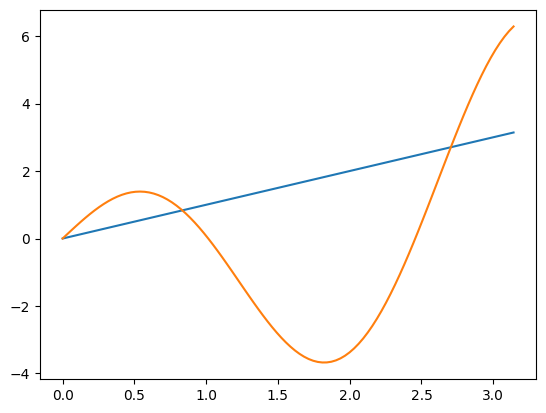

In [109]:
plt.plot(ix, ix)
plt.plot(ix, f_true(ix))

In [110]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.il  = torch.nn.Linear(1,80)
        self.mi  = torch.nn.Linear(80,80)
        self.mi1  = torch.nn.Linear(80,80)
        self.mi2 = torch.nn.Linear(80,40)
        self.ol  = torch.nn.Linear(40,1)

        self.tn  = torch.nn.Tanh()
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self,x):
        u = x
        hidden1 = self.il(u)
        hidden2 = self.mi(self.tn(hidden1))
        hidden2a = self.mi1(self.tn(hidden2))
        hidden3 = self.mi2(self.tn(hidden2a))
        out =  self.ol(self.tn(hidden3))
        return out

In [111]:
boundary = X.boundary_points
true_boundary = torch.FloatTensor([0., 0.]).reshape(2,1) # homogeneous boundary condition

pred_boundary_ritz = np.array([])
pred_boundary_net = np.array([])

ritz_model = rnn.RitzModel()
net_model = Net()

for _ in range(100) :
    pred_boundary_ritz = np.append(pred_boundary_ritz, ritz_model(boundary).detach().numpy())
    pred_boundary_net = np.append(pred_boundary_net, net_model(boundary).detach().numpy())

print(np.mean(pred_boundary_ritz), np.mean(pred_boundary_net))

0.11075706034898758 0.11283481866121292


In [112]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

def Du(x, model):
    u = model(x)
    u_x = grad(flat(u), x, create_graph=True, allow_unused=True)[0]
    z = u_x*x
    u_xx = grad(flat(z), x, create_graph=True, allow_unused=True)[0]
    return u_xx

In [113]:
class MseLoss(torch.nn.Module):
    """
    We want to learn the operator N of the PDE such as N[u] = f, so we will use the MSE loss between the true operator and the predicted one
    """
    def __init__(self):
        super(MseLoss, self).__init__()
        self.mse = torch.nn.MSELoss()
        self.loss = 0.

    def forward(self, operator_approx_in_omega, true_operator_in_omega, output_on_boundary, true_value_on_boundary):
        loss_operator = self.mse(operator_approx_in_omega, true_operator_in_omega)
        loss_on_boundary = self.mse(output_on_boundary, true_value_on_boundary)
        total_loss = loss_operator + loss_on_boundary
        self.loss = total_loss.item()
        return total_loss
    
class PinnLoss(torch.nn.Module):
    def __init__(self):
        super(PinnLoss, self).__init__()
        self.mse = torch.nn.MSELoss()
        self.loss = 0.

    def forward(self, output_u_in_omega, true_u_in_omega, operator_approx_in_omega, true_operator_in_omega, output_on_boundary, true_value_on_boundary):
        loss_data = self.mse(output_u_in_omega, true_u_in_omega)
        loss_physical = self.mse(operator_approx_in_omega, true_operator_in_omega)
        loss_boundary = self.mse(output_on_boundary, true_value_on_boundary)
        total_loss = loss_data + loss_physical + loss_boundary
        self.loss = total_loss.item()
        return total_loss
    
class DeepRitzLoss(torch.nn.Module):
    def __init__(self):
        super(DeepRitzLoss, self).__init__()
        self.mse = torch.nn.MSELoss()
        self.loss = 0.

    def forward(self, x_in_omega, output_u_in_omega, true_operator_in_omega, output_on_boundary, true_value_on_boundary, boundary_regularizer=500):
        grad_u = grad(flat(output_u_in_omega), x_in_omega, create_graph=True, allow_unused=True)[0]

        physical_term1 = x_in_omega*(grad_u**2)
        physical_term2 = true_operator_in_omega*output_u_in_omega
        boundary_loss = self.mse(output_on_boundary, true_value_on_boundary)

        
        total_loss = 0.5*torch.trapz(physical_term1.flatten()) + torch.trapz(physical_term2.flatten()) + boundary_regularizer*boundary_loss
        self.loss = total_loss.item()
        return total_l
￼
￼
oss

In [13]:
# STEP 1 : VERSION WITH DATALOADER

from tqdm import tqdm 

net_model = rnn.RitzModel()
total_params = sum(p.numel() for p in net_model.parameters())
print(total_params)

epochs = 1000
criterion = MseLoss()
optimizer_f = torch.optim.Adam(net_model.parameters(), lr=0.0005)
optimizer_boundary = torch.optim.Adam(net_model.parameters(), lr=0.001)

train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch_i in range(epochs):
    net_model.train()
    train_loss_epoch_i = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch_i+1}', colour='blue'):
        batch.requires_grad = True
        f_batch = torch.FloatTensor(f_true(batch.detach().numpy())).reshape(batch_size_train,1)
        f_batch.requires_grad = True

        optimizer_f.zero_grad()
        optimizer_boundary.zero_grad()

        output_boundary = net_model(X.boundary_points)
        output_f = Du(batch, net_model)

        total_loss = criterion(operator_approx_in_omega=output_f, true_operator_in_omega=f_batch, output_on_boundary=output_boundary, true_value_on_boundary=true_boundary)

        train_loss_epoch_i += criterion.loss
        
        total_loss.backward()
        optimizer_f.step()
        optimizer_boundary.step()

    train_loss_per_epoch.append(train_loss_epoch_i / len(train_loader))

    net_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_val in val_loader:
            f_batch_val = torch.FloatTensor(f_true(batch_val.detach().numpy())).reshape(batch_size_val,1)
            val_loss += (net_model(batch_val) - f_batch_val)**2

    val_loss_per_epoch.append(val_loss.mean())
    # print(f"Epoch {epoch_i+1} : Validation Loss {val_loss}, Train loss {loss_boundary.item() + loss_f.item()}")

    # if epoch % 10 == 0 :
    #     print(f'Epoch {epoch} : Loss boundary {loss_boundary.item()} Loss f {loss_f.item()}')
        

911


Epoch 1000: 100%|██████████| 4/4 [00:00<00:00, 114.02it/s]


In [14]:
# STEP 2 : PINNS + labelled data

from tqdm import tqdm

net_model = rnn.RitzModel()
total_params = sum(p.numel() for p in net_model.parameters())
print(total_params)

epochs = 1000
criterion = PinnLoss()
model_optimizer = torch.optim.Adam(net_model.parameters(), lr=0.0005)

train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch_i in range(epochs):
    net_model.train()
    train_loss_epoch_i = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch_i+1}', colour='blue'):
        batch.requires_grad = True
        f_batch = torch.FloatTensor(f_true(batch.detach().numpy())).reshape(batch_size_train,1)
        f_batch.requires_grad = True
        u_batch = torch.FloatTensor(u_true(batch.detach().numpy())).reshape(batch_size_train,1)
        u_batch.requires_grad = True

        model_optimizer.zero_grad()

        output_omega = net_model(batch)
        output_boundary = net_model(X.boundary_points)
        output_f = Du(batch, net_model)

        total_loss = criterion(output_u_in_omega=output_omega, true_u_in_omega=u_batch, operator_approx_in_omega=output_f, true_operator_in_omega=f_batch, output_on_boundary=output_boundary, true_value_on_boundary=true_boundary)

        train_loss_epoch_i += criterion.loss

        total_loss.backward()
        model_optimizer.step()

    train_loss_per_epoch.append(train_loss_epoch_i / len(train_loader))

    net_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_val in val_loader:
            f_batch_val = torch.FloatTensor(f_true(batch_val.detach().numpy())).reshape(batch_size_val,1)
            val_loss += (net_model(batch_val) - f_batch_val)**2

    val_loss_per_epoch.append(val_loss.mean())
    # print(f"Epoch {epoch_i+1} : Validation Loss {val_loss}, Train loss {loss_boundary.item() + loss_f.item()}")

    # if epoch % 10 == 0 :
    #     print(f'Epoch {epoch} : Loss boundary {loss_boundary.item()} Loss f {loss_f.item()}')
        

911


Epoch 1000: 100%|██████████| 4/4 [00:00<00:00, 46.52it/s]


In [126]:
# STEP 3 : Deep Ritz 

from tqdm import tqdm

M = 1000
mc_points = torch.FloatTensor(np.linspace(0, np.pi, M)).reshape(M,1)
mc_points.requires_grad = True

net_model = rnn.RitzModel()
total_params = sum(p.numel() for p in net_model.parameters())
print(total_params)

epochs = 1000
criterion = DeepRitzLoss()
model_optimizer = torch.optim.Adam(net_model.parameters(), lr=0.0005)

train_loss_per_epoch = []

for epoch_i in range(epochs):
    net_model.train()
    train_loss_epoch_i = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch_i+1}', colour='blue'):
        batch.requires_grad = True
        f_batch = torch.FloatTensor(f_true(mc_points.detach().numpy())).reshape(M,1)
        f_batch.requires_grad = True
    
        model_optimizer.zero_grad()

        output_omega = net_model(mc_points)
        output_boundary = net_model(X.boundary_points)

        total_loss = criterion(x_in_omega=mc_points, output_u_in_omega=output_omega, true_operator_in_omega=f_batch, output_on_boundary=output_boundary, true_value_on_boundary=true_boundary)
        train_loss_epoch_i += total_loss.item()
        
        total_loss.backward()
        model_optimizer.step()

    train_loss_per_epoch.append(train_loss_epoch_i / len(train_loader))
        

911


Epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1000: 100%|██████████| 4/4 [00:00<00:00, 15.64it/s]


In [46]:
def plot_prediction(model, x: np.ndarray):
    x = torch.FloatTensor(x).reshape(len(x),1)
    u = model(x)
    plt.plot(x, u_true(x) ,  linewidth=6, color='black', label='True solution')
    plt.plot(x, u.detach().numpy(), linewidth=2, color='red', label='Approximated solution')
    plt.legend()
    print(f"Error minimum : {min(abs(u.detach().numpy() - u_true(x).detach().numpy()))}, Error maximum : {max(abs(u.detach().numpy() - u_true(x).detach().numpy()))}, Error mean : {np.mean(abs(u.detach().numpy() - u_true(x).detach().numpy()))}")
    return

Error minimum : [1.14142895e-05], Error maximum : [0.00760195], Error mean : 0.0031313470099121332


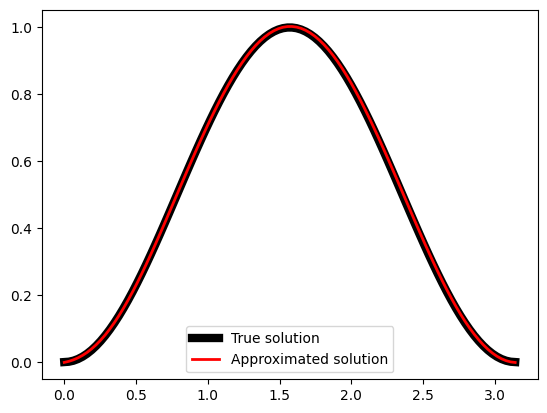

In [132]:
plot_prediction(net_model, np.linspace(0, np.pi, 100))

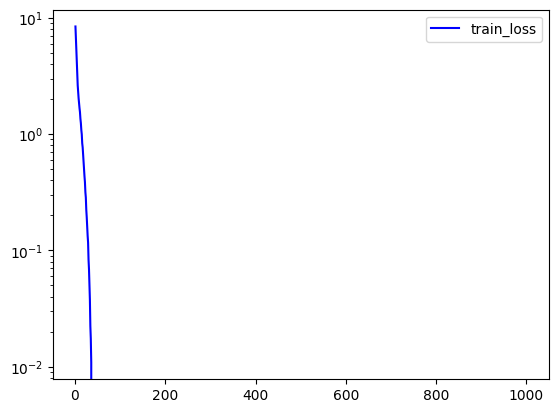

In [117]:
xx = np.linspace(1, epochs, epochs)
plt.plot(xx, train_loss_per_epoch, label = 'train_loss', color='blue')
# plt.plot(xx, val_loss_per_epoch, label = 'val_loss', color='red')
plt.yscale('log')
plt.legend()
plt.show()